In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3
import scoobi.scoobi as scoobi
import scoobi.utils as utils

import lina

print(scoobi.__file__)
print(lina.__file__)

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()

client = IndiClient()
client.connect()
client.get_properties()

def restart_clients():
    client0 = INDIClient('localhost', 7624)
    client0.start()

    client = IndiClient()
    client.connect()
    client.get_properties()

/opt/conda/envs/km310env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


/home/kianmilani/Projects/scoob-interface/scoobi/scoobi.py
/home/kianmilani/Projects/lina/lina/__init__.py


In [2]:
scoobi.home_block(client0)

In [4]:
scoobi.move_block_out(client0)

In [2]:
reload(scoobi)
xc, yc = (4600, 3400)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)


In [20]:
scoobi.move_psf(-2, 0, client0)

In [13]:
scoobi.move_psf(0, 3, client0)

In [4]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', dm_channel='dm00disp02')
bias = 800e-9 * np.ones((I.Nact,I.Nact))*I.dm_mask

In [21]:
I.zero_dm()

In [8]:
I.set_dm(bias)

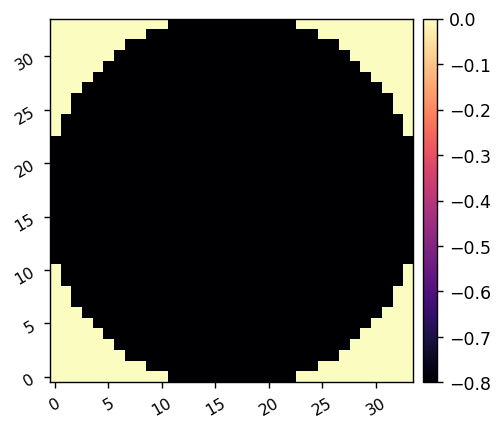

In [6]:
imshow1(I.DMT.grab_latest())

In [10]:
reload(scoobi)
I.set_zwo_exp_time(0.000120, client0)

Set the ZWO exposure time to 1.20e-04s


In [11]:
reload(scoobi)
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [19]:
reload(scoobi)
I.set_fib_atten(5, client)

Set the fiber attenuation to 5.0


INFO:utils:Got semaphore index 1.


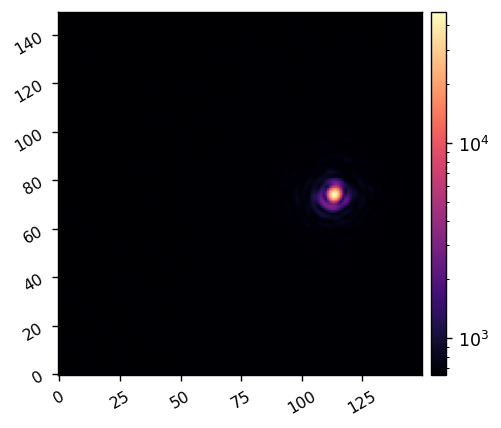

In [19]:
I.NSCICAM = 100
I.return_ni = 0
I.subtract_dark = 0
psf = I.snap()
imshow1(psf, lognorm=1, )


In [20]:
utils.save_fits('new_dm_install_initial_psf.fits', psf)

Saved data to:  new_dm_install_initial_psf.fits


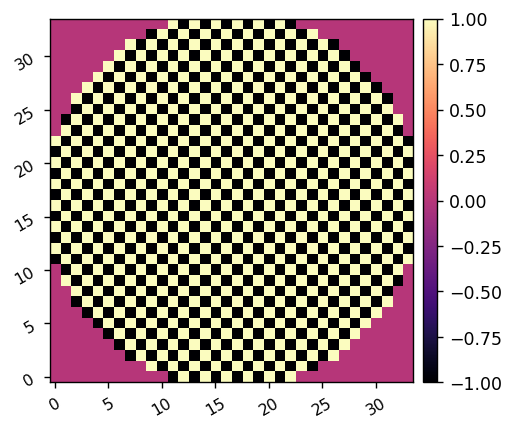

In [21]:
reload(scoobi.utils)
waffle_command = scoobi.utils.create_fourier_command(x_cpa=17, y_cpa=17) * xp.array(I.dm_mask)
imshow1(waffle_command)

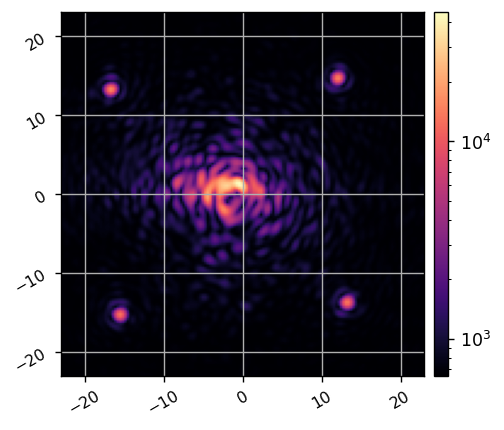

In [30]:
I.add_dm(15e-9 * waffle_command)
I.x_shift = 0
I.y_shift = 0

I.NSCICAM = 100
# I.subtract_dark = True
# I.return_ni = True
waffle_im = I.snap()
imshow1(waffle_im, lognorm=True, pxscl=I.psf_pixelscale_lamDc, grid=True)

Centroids:
 [[ 23.88108952  24.63680205]
 [ 20.12832805 117.57811451]
 [113.60975543 122.35365981]
 [117.49526086  29.74518674]
 [ 23.88108952  24.63680205]]


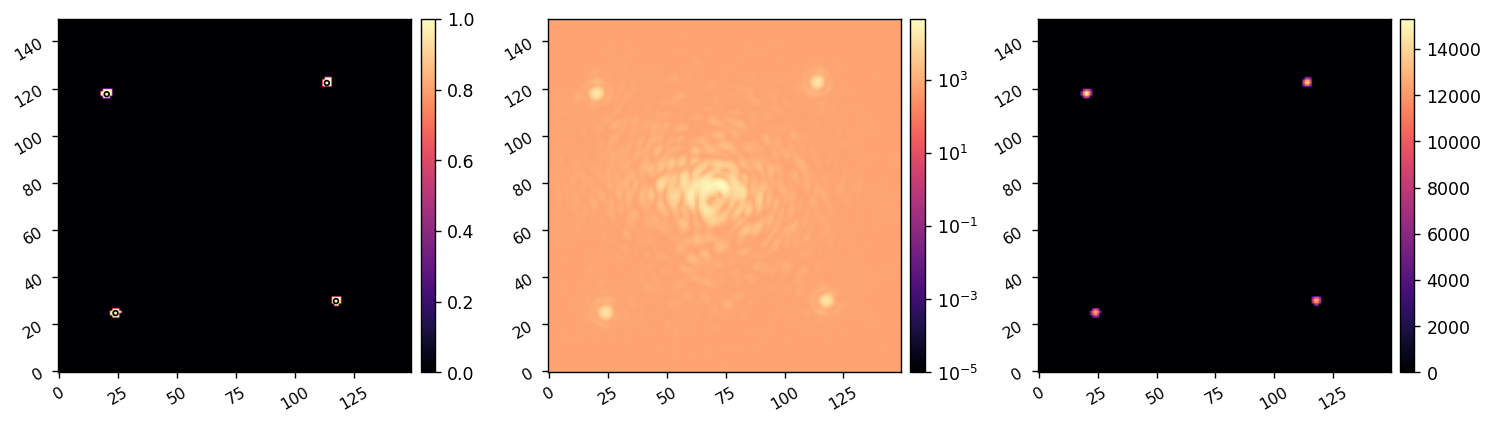

Angle:  87.30934634957705
Measured center in X:  68.85907410836012
Measured center in Y:  73.61900051718848
Required shift in X:  6.0
Required shift in Y:  1.0


In [32]:
reload(scoobi.utils)

xshift,yshift,angle = scoobi.utils.measure_center_and_angle(waffle_im, I.psf_pixelscale_lamDc, im_thresh=5e3, r_thresh=16)

In [ ]:
I.set_dm()

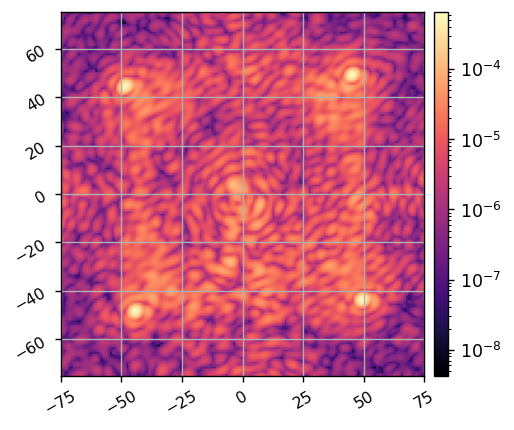

In [19]:
I.Nframes = 10
I.npsf = 150
I.x_shift = xshift
I.y_shift = yshift

I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()
imshow1(coro_im, lognorm=True, pxscl=1, grid=True)

In [20]:
I.zero_dm()

# Choose modes and probes for iEFC

In [21]:
reload(lina.utils)

iwa = 2.5
owa = 11
rotation = 180
control_mask = lina.utils.create_annular_focal_plane_mask(
    I.npsf, 
    I.psf_pixelscale_lamDc, 
    iwa, 
    owa, 
    edge=iwa, 
    rotation=rotation,
)

5.80302656444793e-06


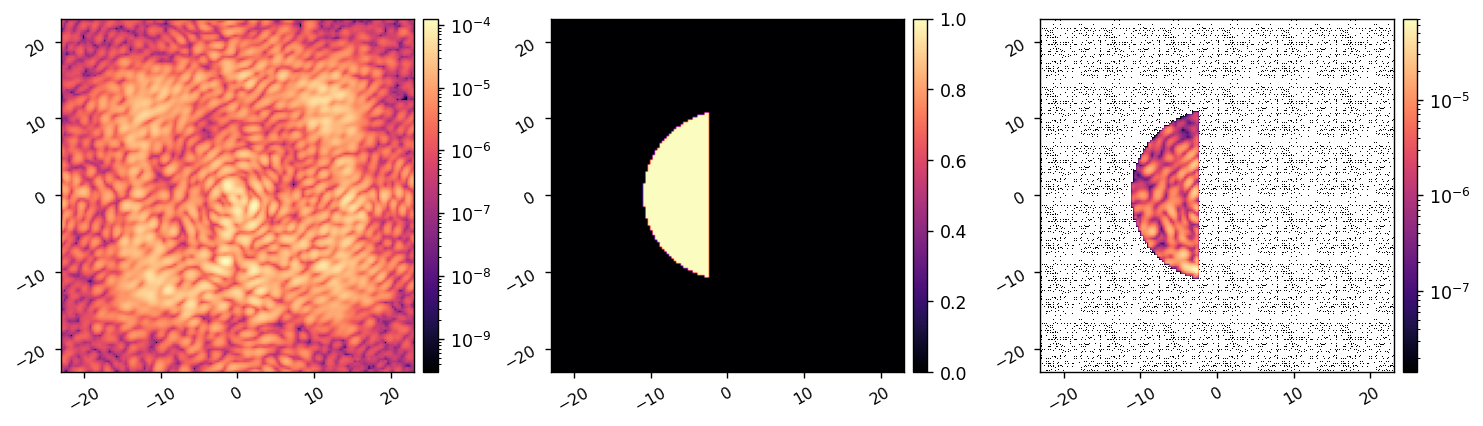

In [23]:
I.zero_dm()
I.NSCICAM = 20
I.subtract_dark = True
I.return_ni = True
# I.set_zwo_exp_time(0.0005, client0)

ref_coro_im = I.snap()
print(xp.mean(ref_coro_im[control_mask]))
imshow3(ref_coro_im, control_mask, control_mask * ref_coro_im,
        lognorm1=True, lognorm3=True, pxscl=I.psf_pixelscale_lamDc)

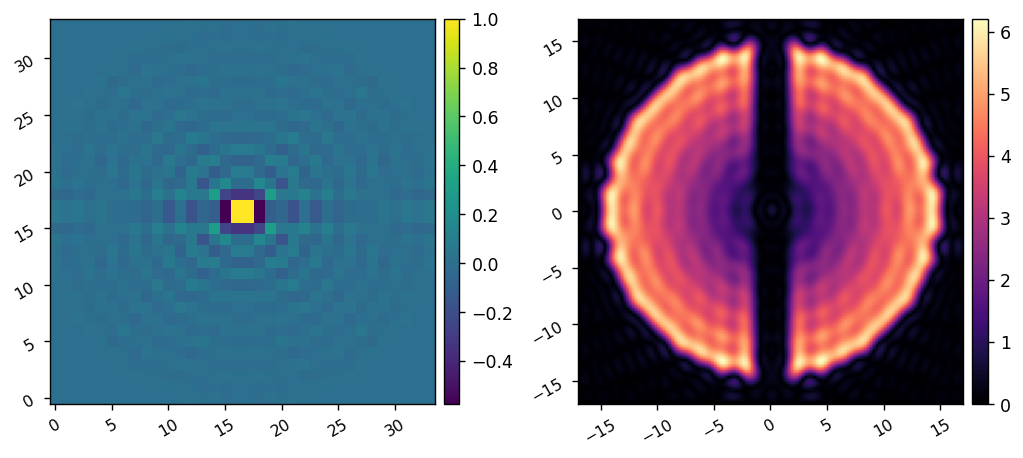

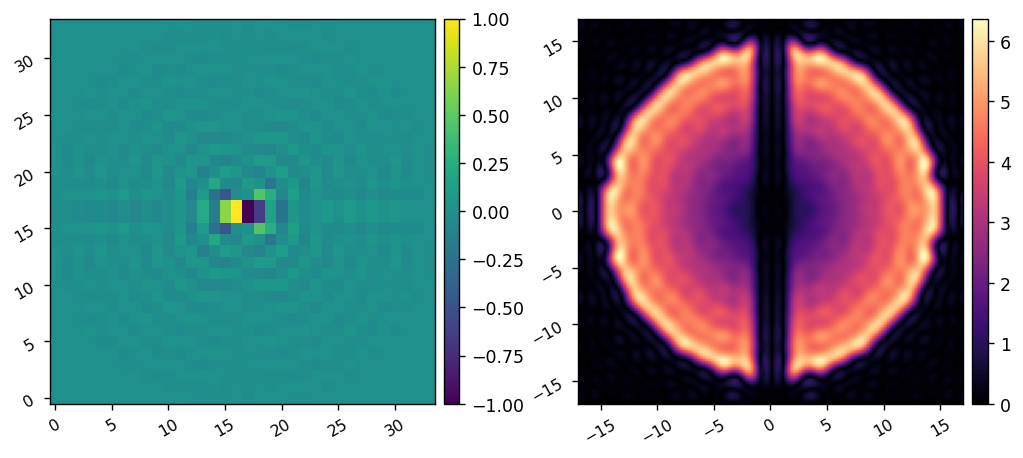

In [24]:
reload(lina.utils)
probe_iwa = 2
probe_owa = 14

probe_modes = lina.utils.create_fourier_probes(
    xp.array(I.dm_mask), 
    I.npsf, 
    I.psf_pixelscale_lamDc, 
    probe_iwa, 
    probe_owa, 
    rotation=rotation,
    fourier_sampling=0.75, 
    shifts=None, 
    nprobes=2,
    use_weighting=True, 
    plot=True,
)

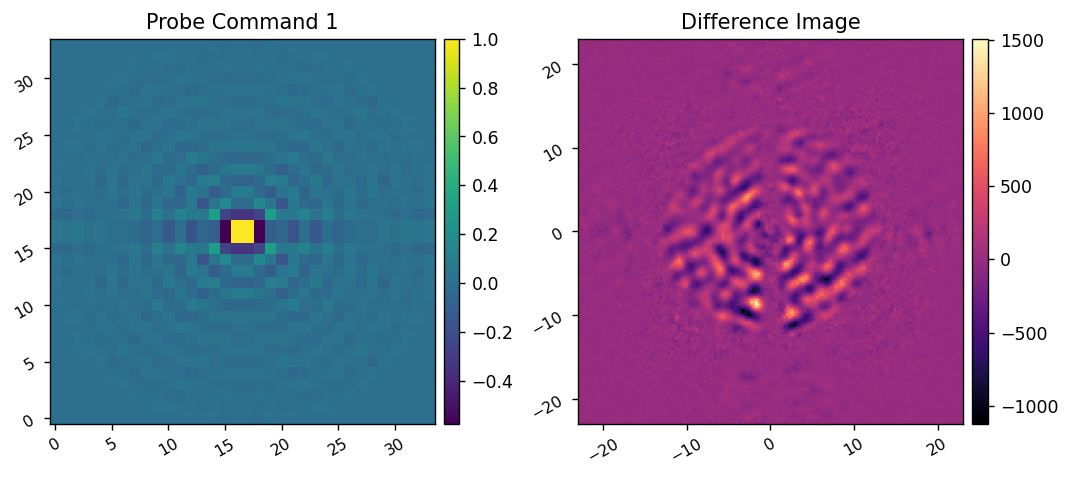

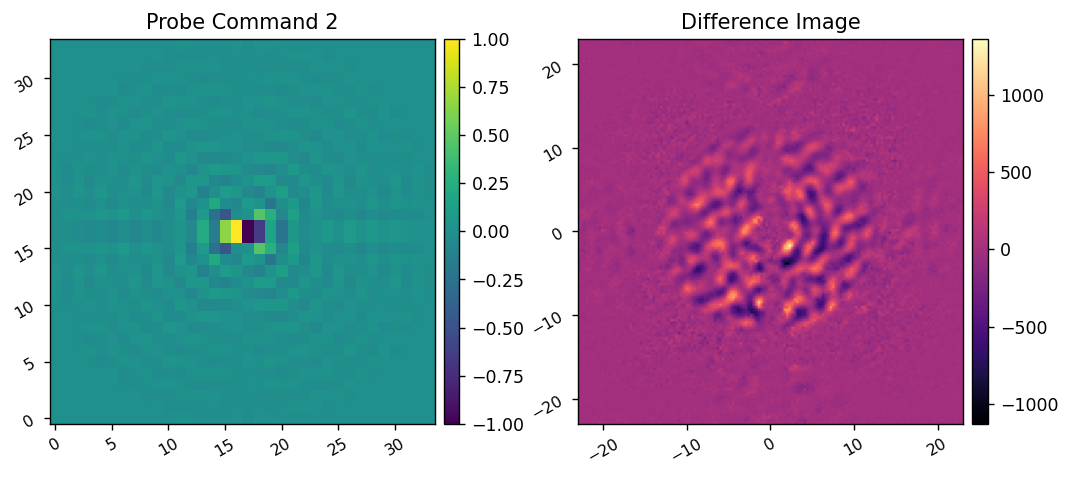

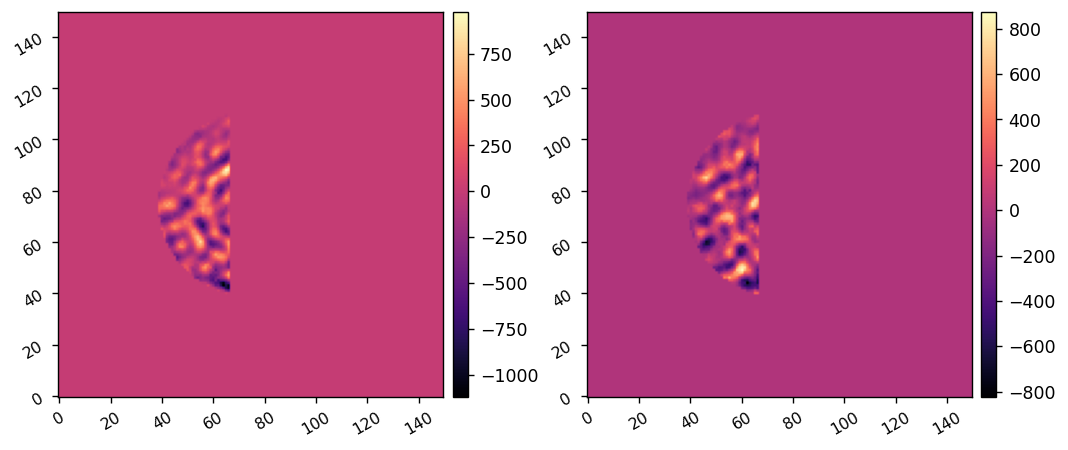

In [25]:
reload(lina.iefc)

time.sleep(3)
I.NSCICAM = 30
I.subtract_dark = False
I.return_ni = True

diff_ims = lina.iefc.take_measurement(
    I, 
    probe_modes, 
    3e-9, 
    plot=True,
)
diff_ims *= control_mask
imshow2(diff_ims[0], diff_ims[1])
# imshow3(diff_ims[0], diff_ims[1], diff_ims[2])

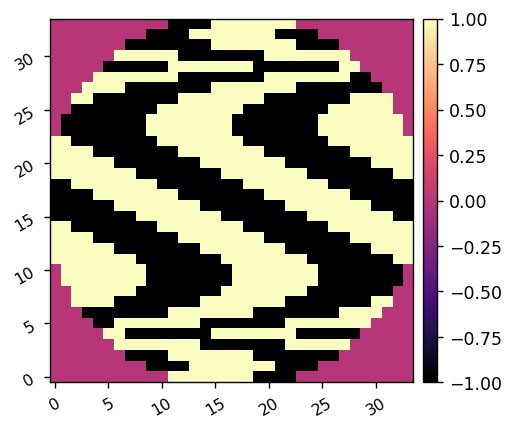

In [26]:
reload(lina.utils)
calib_modes = lina.utils.create_hadamard_modes(xp.array(I.dm_mask))
imshow1(calib_modes[8])


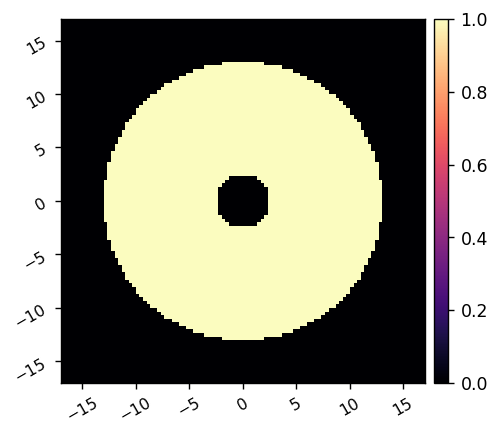

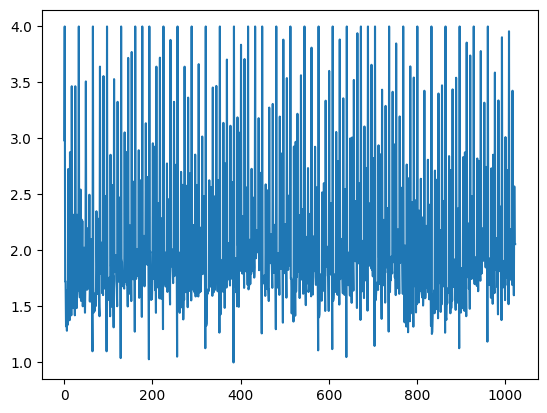

[1.33681368 2.72723075 1.93211861 2.05180468]


In [27]:
reload(lina.iefc)
scale_factors = lina.iefc.compute_hadamard_scale_factors(calib_modes, scale_exp=1/4, scale_thresh=4, oversamp=3, plot=True)
print(scale_factors[8:12])

In [30]:
I.zero_dm()

In [29]:
reload(lina.iefc)
I.zero_dm()

probe_amp = 3e-9
calib_amp = 2.25e-9

I.NSCICAM = 10
I.return_ni = True
I.subtract_dark = False
I.dm_delay = I.texp * 3
print(I.dm_delay)

# time.sleep(2)
response_matrix, response_cube = lina.iefc.calibrate(
    I, 
    control_mask, 
    probe_amp, 
    probe_modes, 
    calib_amp, 
    calib_modes, 
    scale_factors=scale_factors, 
#  calib_amp, calib_modes[100:110], 
#  scale_factors=scale_factors[100:110], 
#  calib_amp, calib_modes[8:12], 
#  scale_factors=scale_factors[8:12], 
    return_all=True,
)

0.003
Calibrating iEFC...


KeyboardInterrupt: 

In [77]:
iefc_calib_data = {
    'response_matrix':response_matrix,
    'response_cube':response_cube,
    'control_mask':control_mask,
    'NSCICAM':I.NSCICAM,
    'probe_amp':probe_amp,
    'probe_modes':probe_modes,
    'calib_amp':calib_amp,
    'scale_factors':scale_factors,
}
lina.utils.save_pickle(f'../data/llowfsc+iefc/{today}_iefc_calib_1.pkl', iefc_calib_data)

Saved data to:  ../data/llowfsc+iefc/20241217_iefc_calib_1.pkl


In [92]:
response_cube = utils.load_pickle(f'../data/llowfsc+iefc/{today}_iefc_hadamard_jac_cube_1.pkl')
response_matrix = response_cube[:, :, control_mask.ravel()].reshape(1024, -1).T

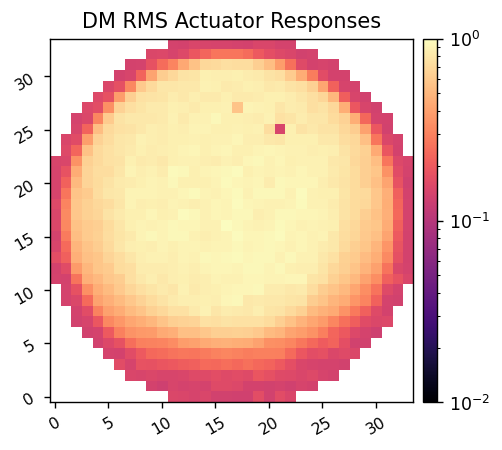

In [78]:
dm_response_map = xp.sqrt(xp.mean(xp.square(response_matrix.dot(calib_modes.reshape(1024, -1))), axis=0))
dm_response_map = dm_response_map.reshape(I.Nact,I.Nact) / xp.max(dm_response_map)
imshow1(dm_response_map, 'DM RMS Actuator Responses', lognorm=True, vmin=1e-2)

In [90]:
cm1 = lina.utils.beta_reg(response_matrix, -2)
cm2 = lina.utils.beta_reg(response_matrix, -5)


In [80]:
I.zero_dm()
data = {
    'images':[ref_coro_im],
    'commands':[],
    'del_commands':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
    'probes':probe_modes,
}

0.30000000000000004
Running iEFC...
	Closed-loop iteration 13 / 15


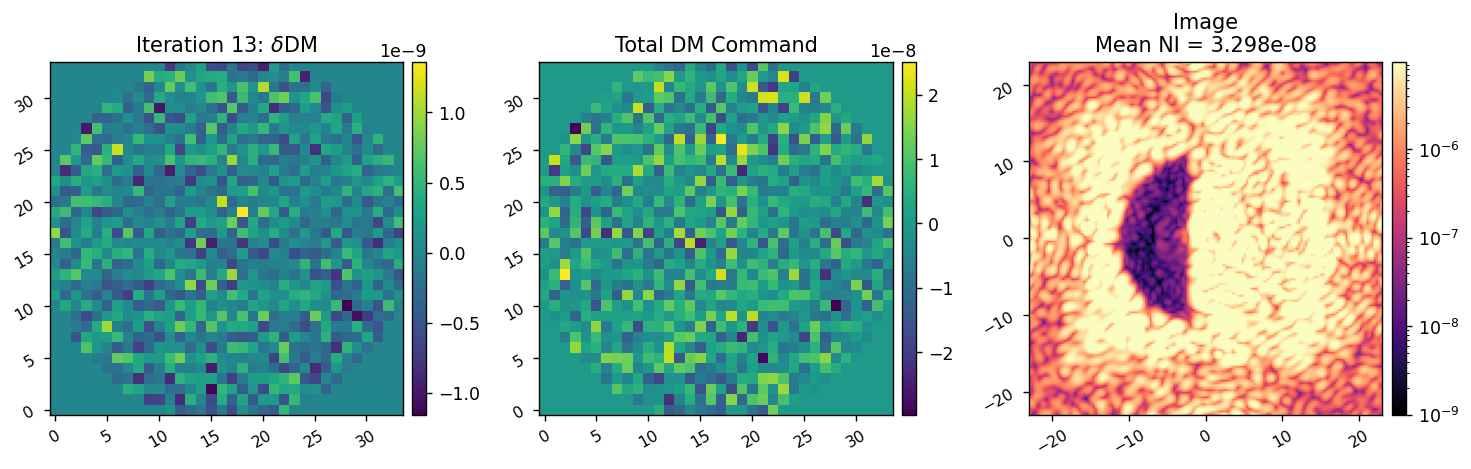

	Closed-loop iteration 14 / 15


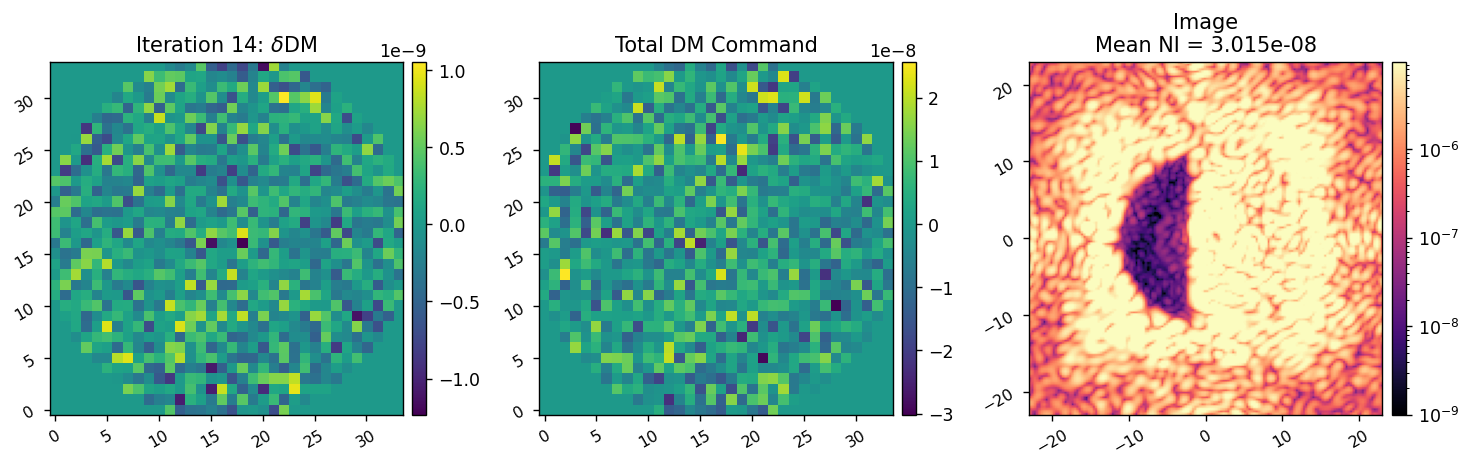

	Closed-loop iteration 15 / 15


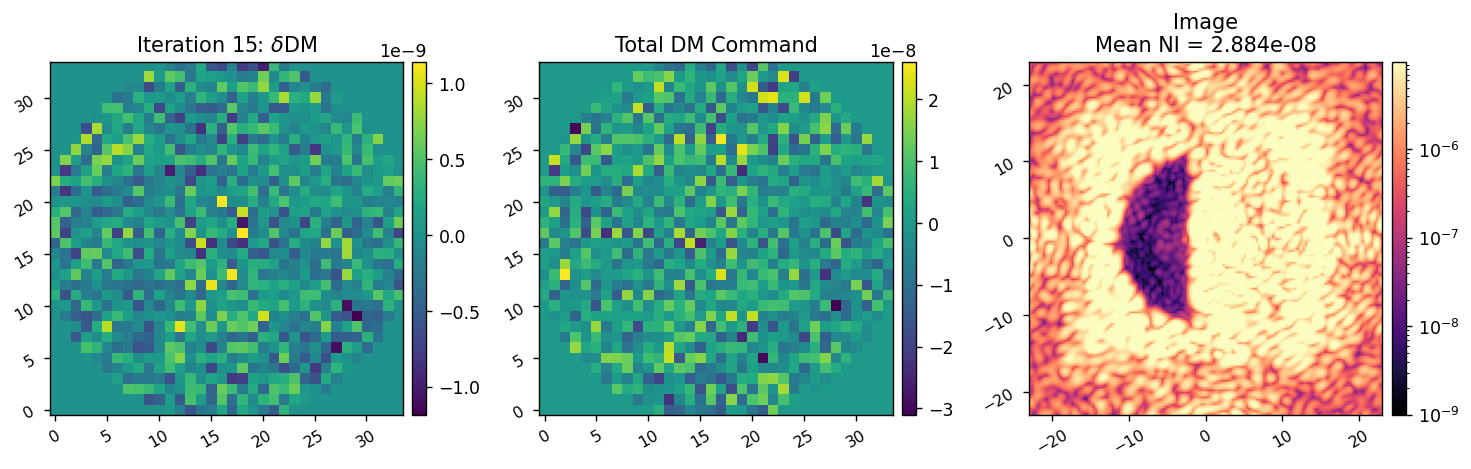

Closed loop for given control matrix completed in 41.686s.


In [91]:
reload(lina.utils)
reload(lina.iefc)

probe_amp = 5e-9
probe_amp = 4e-9
probe_amp = 3e-9
probe_amp = 2.5e-9
# probe_amp = 2e-9
# probe_amp = 1.5e-9
probe_amp = 1e-9
probe_amp = 0.75e-9
# probe_amp = 0.5e-9

I.NSCICAM = 20
I.return_ni = True
I.dm_delay = 3*I.texp
print(I.dm_delay)

data = lina.iefc.run(
    I,
    data,
    cm1,
    # cm2,
    probe_modes, 
    probe_amp, 
    calib_modes,
    control_mask,
    num_iterations=3,
    loop_gain=0.75, 
    leakage=0.0,
    plot_current=True,
    plot_all=True,
    plot_probes=False,
    plot_radial_contrast=False,
)

In [97]:
I.texp

0.001

In [82]:
# I.set_fib_atten(5, client)
I.set_zwo_exp_time(0.1, client0, delay=1)
I.set_zwo_gain(120, client0)

Set the ZWO exposure time to 1.00e-01s
Set the ZWO gain setting to 120.0


In [83]:
reload(scoobi)
scoobi.move_block_in(client0)

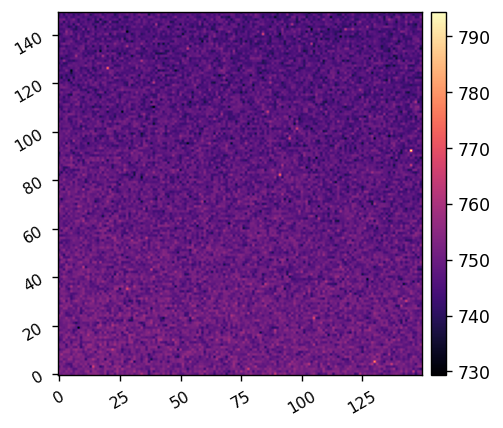

In [84]:
I.NSCICAM = 100
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()
imshow1(dark_frame)

I.df = copy.copy(dark_frame)

In [85]:
reload(scoobi)
scoobi.move_block_out(client0)

6.867151192100416e-08


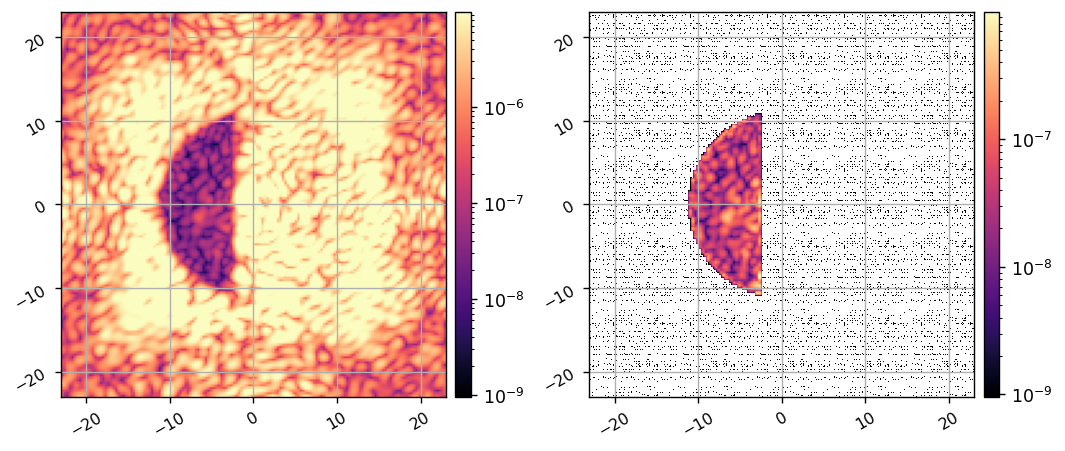

In [86]:
I.NSCICAM = 20
I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()

print(xp.mean(coro_im[control_mask]))
imshow2(coro_im, control_mask * coro_im, grid=True, lognorm=True, pxscl=I.psf_pixelscale_lamDc)

# Shrink control region

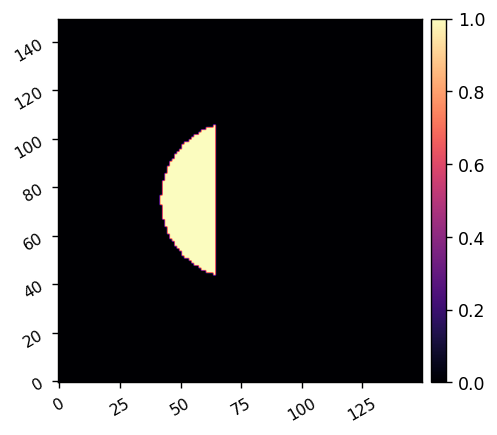

In [92]:
new_iwa = 3
new_owa = 10
new_control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, new_iwa, new_owa, edge=new_iwa, rotation=rotation)
imshow1(new_control_mask)

In [93]:
new_response_matrix = response_cube[:, :, new_control_mask.ravel()].reshape(1024, -1).T
new_response_matrix.shape

(2044, 1024)

In [94]:
cm1 = lina.utils.beta_reg(new_response_matrix, -2)
cm2 = lina.utils.beta_reg(new_response_matrix, -3.5)
cm3 = lina.utils.beta_reg(new_response_matrix, -5)

0.30000000000000004
Running iEFC...
	Closed-loop iteration 64 / 66


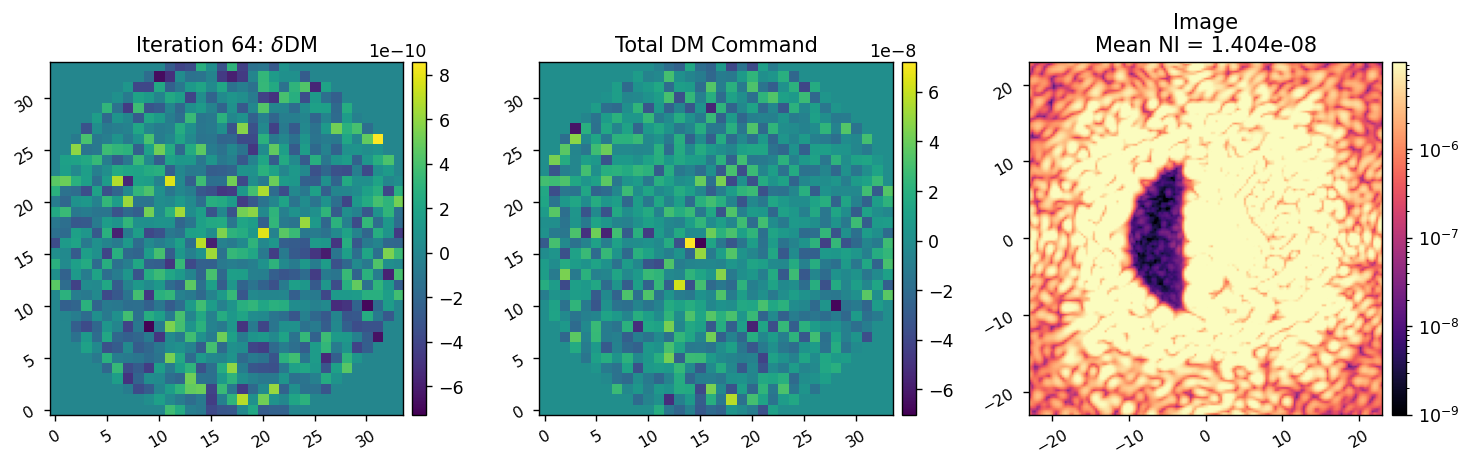

	Closed-loop iteration 65 / 66


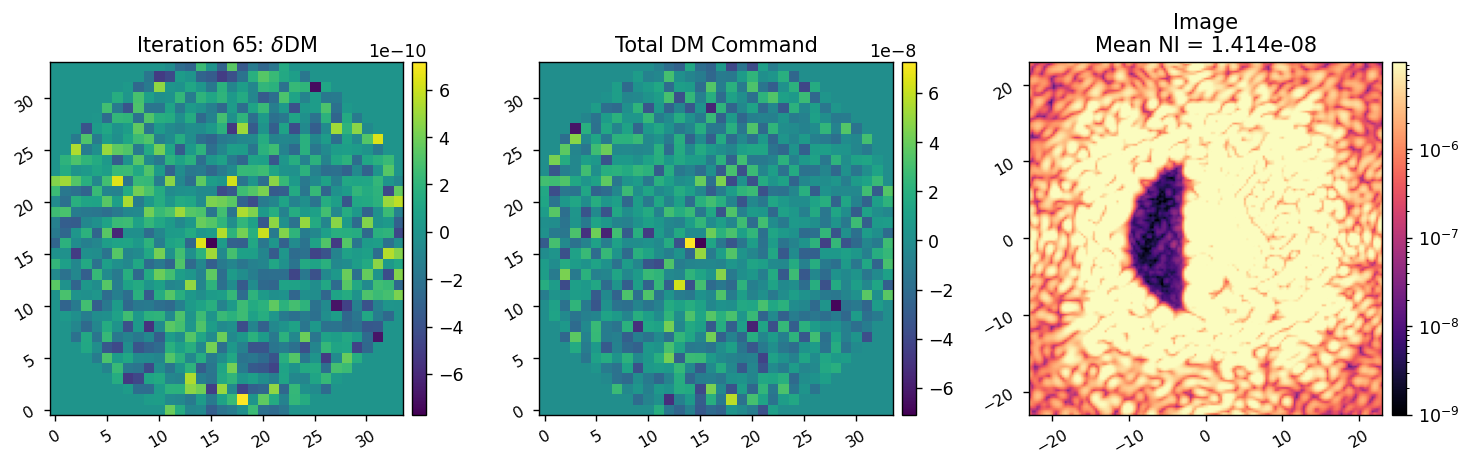

	Closed-loop iteration 66 / 66


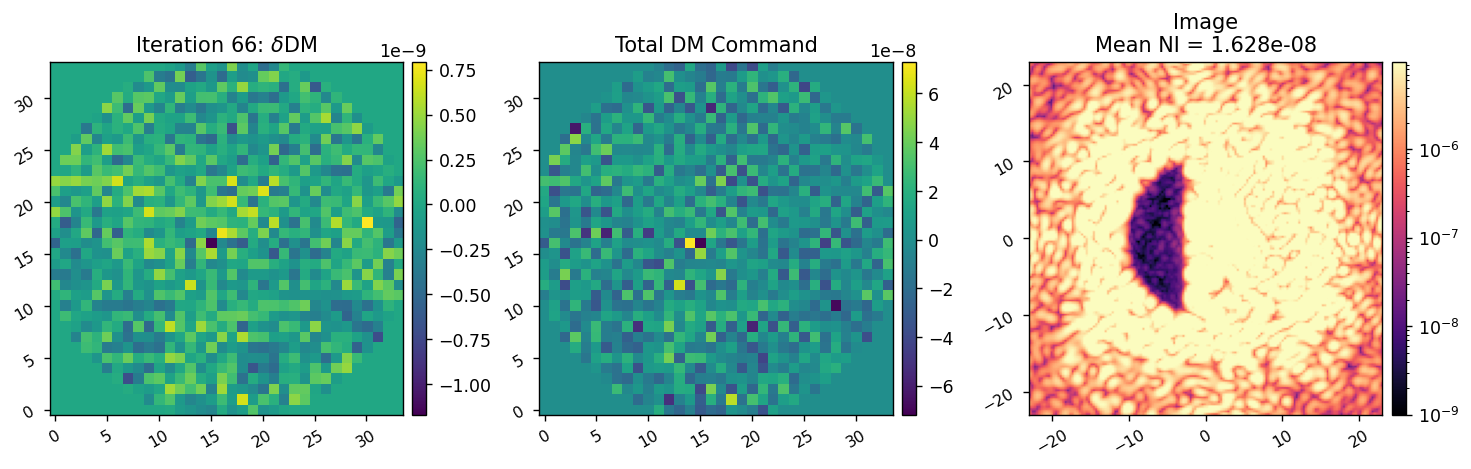

Closed loop for given control matrix completed in 71.657s.


In [132]:
reload(lina.utils)
reload(lina.iefc)


probe_amp = 5e-9
probe_amp = 4e-9
probe_amp = 3e-9
# probe_amp = 2.5e-9
# probe_amp = 2e-9
probe_amp = 1.5e-9
probe_amp = 1e-9
probe_amp = 0.75e-9
probe_amp = 0.5e-9
# probe_amp = 0.3e-9

I.NSCICAM = 40
I.return_ni = True
I.dm_delay = 3*I.texp
print(I.dm_delay)

data = lina.iefc.run(
    I,
    data,
    cm1,
    # cm2,
    # cm3,
    probe_modes, probe_amp, 
    calib_modes,
    new_control_mask,
    num_iterations=3,
    loop_gain=0.75, 
    leakage=0.0,
    plot_current=True,
    plot_all=True,
    plot_probes=False,
    plot_radial_contrast=False,
)

1.224629534649882e-08


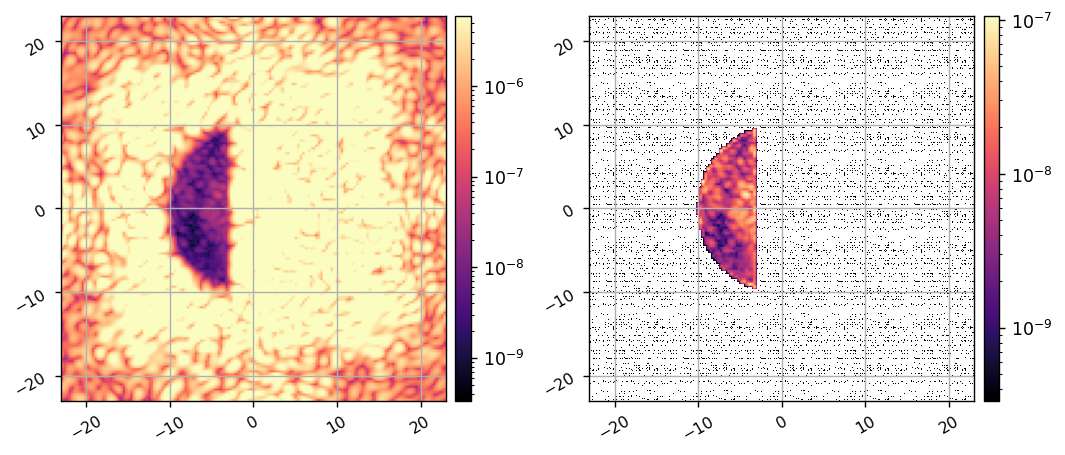

In [237]:
I.NSCICAM = 20
I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()

print(xp.mean(coro_im[new_control_mask]))
imshow2(coro_im, new_control_mask * coro_im, grid=True, lognorm=True, pxscl=I.psf_pixelscale_lamDc)

In [128]:
data.update({'control_mask_2':new_control_mask})
lina.utils.save_pickle(f'../data/llowfsc+iefc/{today}_iefc_run_1.pkl', data)


Saved data to:  ../data/llowfsc+iefc/20241217_iefc_run_1.pkl


# Test a single iteration of iEFC. 

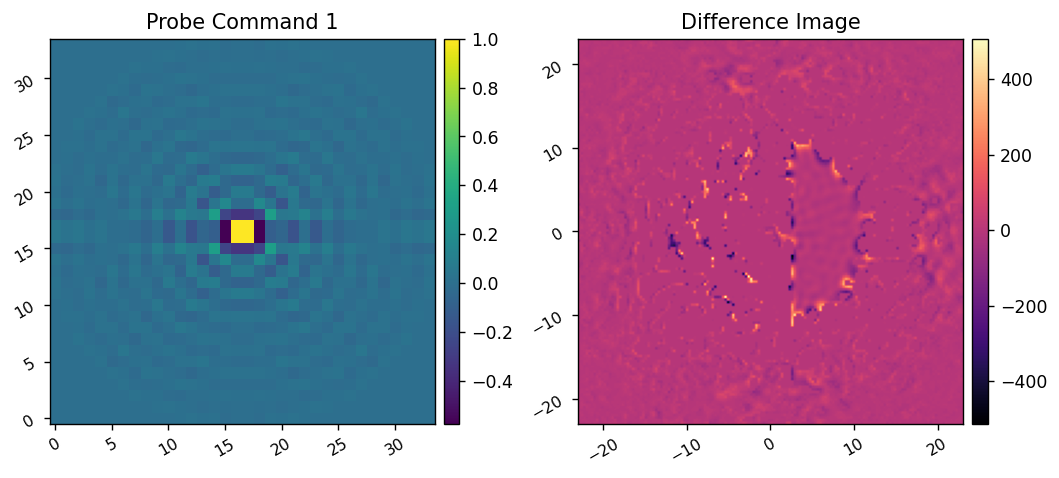

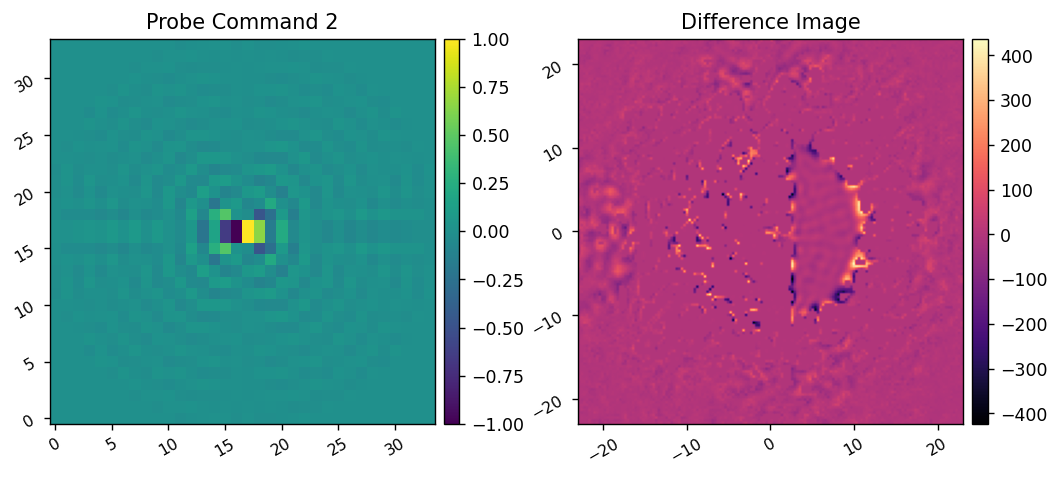

(1024, 2044) (2044,)


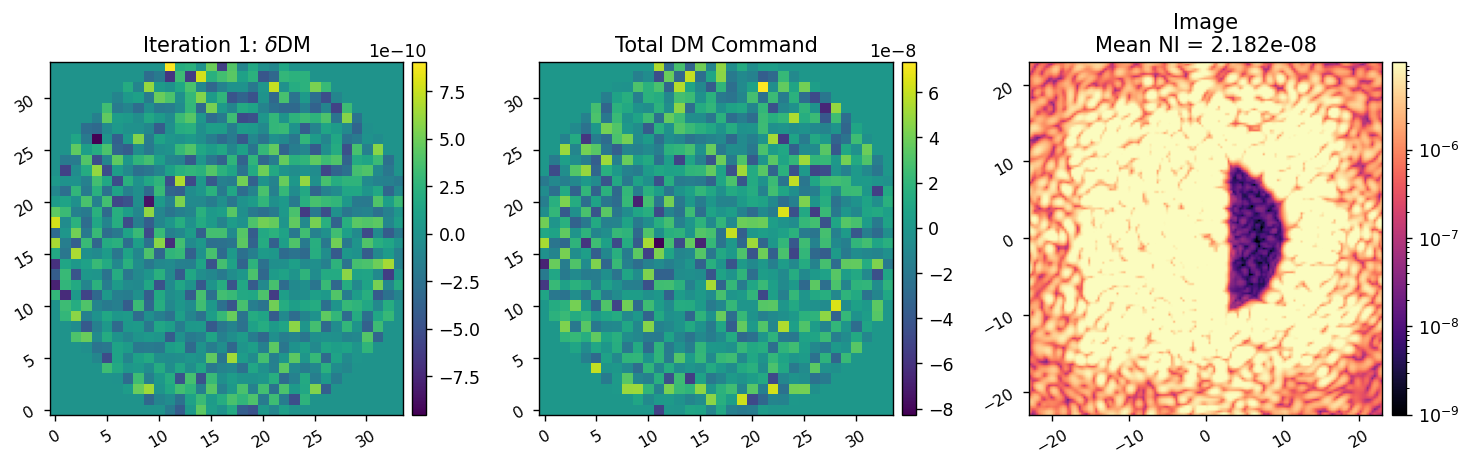

In [142]:
reload(lina.iefc)
probe_amp = 0.75e-9
modal_matrix = calib_modes.reshape(1024, -1)
cm = lina.utils.beta_reg(new_response_matrix, -2.5)

lina.iefc.single_iteration(
    I, 
    probe_modes, 
    probe_amp, 
    cm, 
    modal_matrix, 
    new_control_mask, 
    gain=0.5, 
    plot=True, 
    plot_probes=True,
)

# Define a continuoius iEFC process and run it in the background.

In [117]:
reload(lina.iefc)
iefc_interval = 120
I.dm_delay = 2*I.texp

probe_amp = 0.3e-9
modal_matrix = calib_modes.reshape(1024, -1)
cm = lina.utils.beta_reg(new_response_matrix, -2)

args = [
    I, 
    probe_modes, 
    probe_amp, 
    cm, 
    modal_matrix, 
    new_control_mask,
]

kwargs = {
    'gain':0.75,
    'plot':True,
    # 'plot_probes':True,
    # 'clear':False, 
}

iefc_process = lina.utils.Process(
    iefc_interval, 
    lina.iefc.single_iteration, 
    args, # the args
    kwargs, # the kwargs
)

In [118]:
iefc_process.start()

In [122]:
iefc_process.cancel()

In [123]:
I.set_dm(data['commands'][-1])

# Monitor the dark hole

In [133]:
reload(scoobi)
from pathlib import Path

duration = 1800
# duration = 10
I.NSCICAM = 40

# time.sleep(5)
scoobi.stream_scicam(
    I, 
    duration=duration, 
    control_mask=new_control_mask, 
    # fname=f'../data/llowfsc+iefc/{today}_camsci_stream_1.pkl',
    # fname=f'../data/llowfsc+iefc/{today}_camsci_stream_2.pkl',
    # fname=f'../data/llowfsc+iefc/{today}_camsci_stream_3.pkl',
    # fname=f'../data/llowfsc+iefc/{today}_camsci_stream_4.pkl',
    fname=f'../data/llowfsc+iefc/{today}_camsci_stream_5.pkl',
    # fname=f'../data/llowfsc+iefc/{today}_camsci_stream_6.pkl',
)

Stopping camsci stream!
Saved data to:  ../data/llowfsc+iefc/20241217_camsci_stream_5.pkl


In [134]:
I.zero_dm()

In [135]:
I.set_zwo_exp_time(0.001, client0)

Set the ZWO exposure time to 1.00e-03s


In [125]:
I.zero_dm()


In [5]:
28*137*10

38360